In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import bayesflow as bf

2024-05-01 09:36:35.703414: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 09:36:35.755435: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 09:36:36.014237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 09:36:36.014294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 09:36:36.055422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
np.set_printoptions(suppress=True)
RNG = np.random.default_rng(7373)

Goal is to predict gaze position $(x, y)$ based upon angular position $\theta$

In [4]:
# Read in the dataset
dataset = pd.read_csv('./data/full_data2.csv', delimiter=";", usecols=['Gaze.x.', 'Gaze.y.', 'Subject', 'Ang_Pos', 'Lap_Number'])
dataset.shape

(194758, 5)

## The model

Hyperprior

\begin{equation}

\end{equation}

Conditional prior

\begin{equation}
    
\end{equation}

Joint model

\begin{align}
    x \sim \mathcal{N}(\alpha_x + \beta_x \theta, \sigma_x), \\
    y \sim \mathcal{N}(\alpha_y + \beta_y \theta, \sigma_y).
\end{align}

In [5]:
# Simulating just so this is not stupid.
N_OBS = 1000
angular_pos = RNG.gamma(0.5, 1., size=N_OBS)

In [66]:
PARAMS = [
    r'$\alpha_x$', 
    r'$\beta_x$', 
    r'$\sigma_x$', 
    r'$\alpha_y$',
    r'$\beta_y$', 
    r'$\sigma_y$',
    r'$\theta$'
]

In [54]:
def prior_fun(rng=None):

    if rng is None:
        rng = np.random.default_rng()

    alpha_x = rng.normal(0, 5)
    alpha_y = rng.normal(0, 1)
    beta_x = rng.normal(0, 10)
    beta_y = rng.normal(0, 1)
    sigma_x = rng.gamma(5, 5)
    sigma_y = rng.gamma(0.5, 10)
    angular_pos = RNG.gamma(0.5, 1.)

    theta = np.array([alpha_x, alpha_y, beta_x, beta_y, sigma_x, sigma_y, angular_pos])
    return theta

In [55]:
def simulator_fun(theta, n_obs=1000, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    alpha_x, alpha_y, beta_x, beta_y, sigma_x, sigma_y, angular_pos = theta

    x = RNG.normal(alpha_x + beta_x * angular_pos, sigma_x, size=n_obs)
    y = RNG.normal(alpha_y + beta_y * angular_pos, sigma_y, size=n_obs)

    return np.array([x, y])

In [62]:
theta = prior_fun(rng=RNG)
gaze_pos = simulator_fun(theta, rng=RNG)
gaze_pos.shape

(2, 1000)

<Axes: >

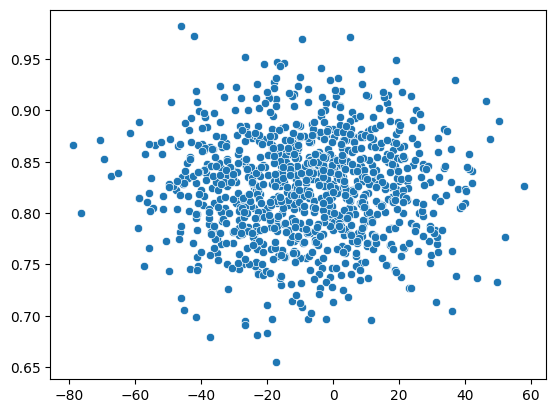

In [63]:
sns.scatterplot(x=gaze_pos[0], y=gaze_pos[1])

In [67]:
prior = bf.simulation.Prior(prior_fun=prior_fun, param_names=PARAMS)

Prior predictive check

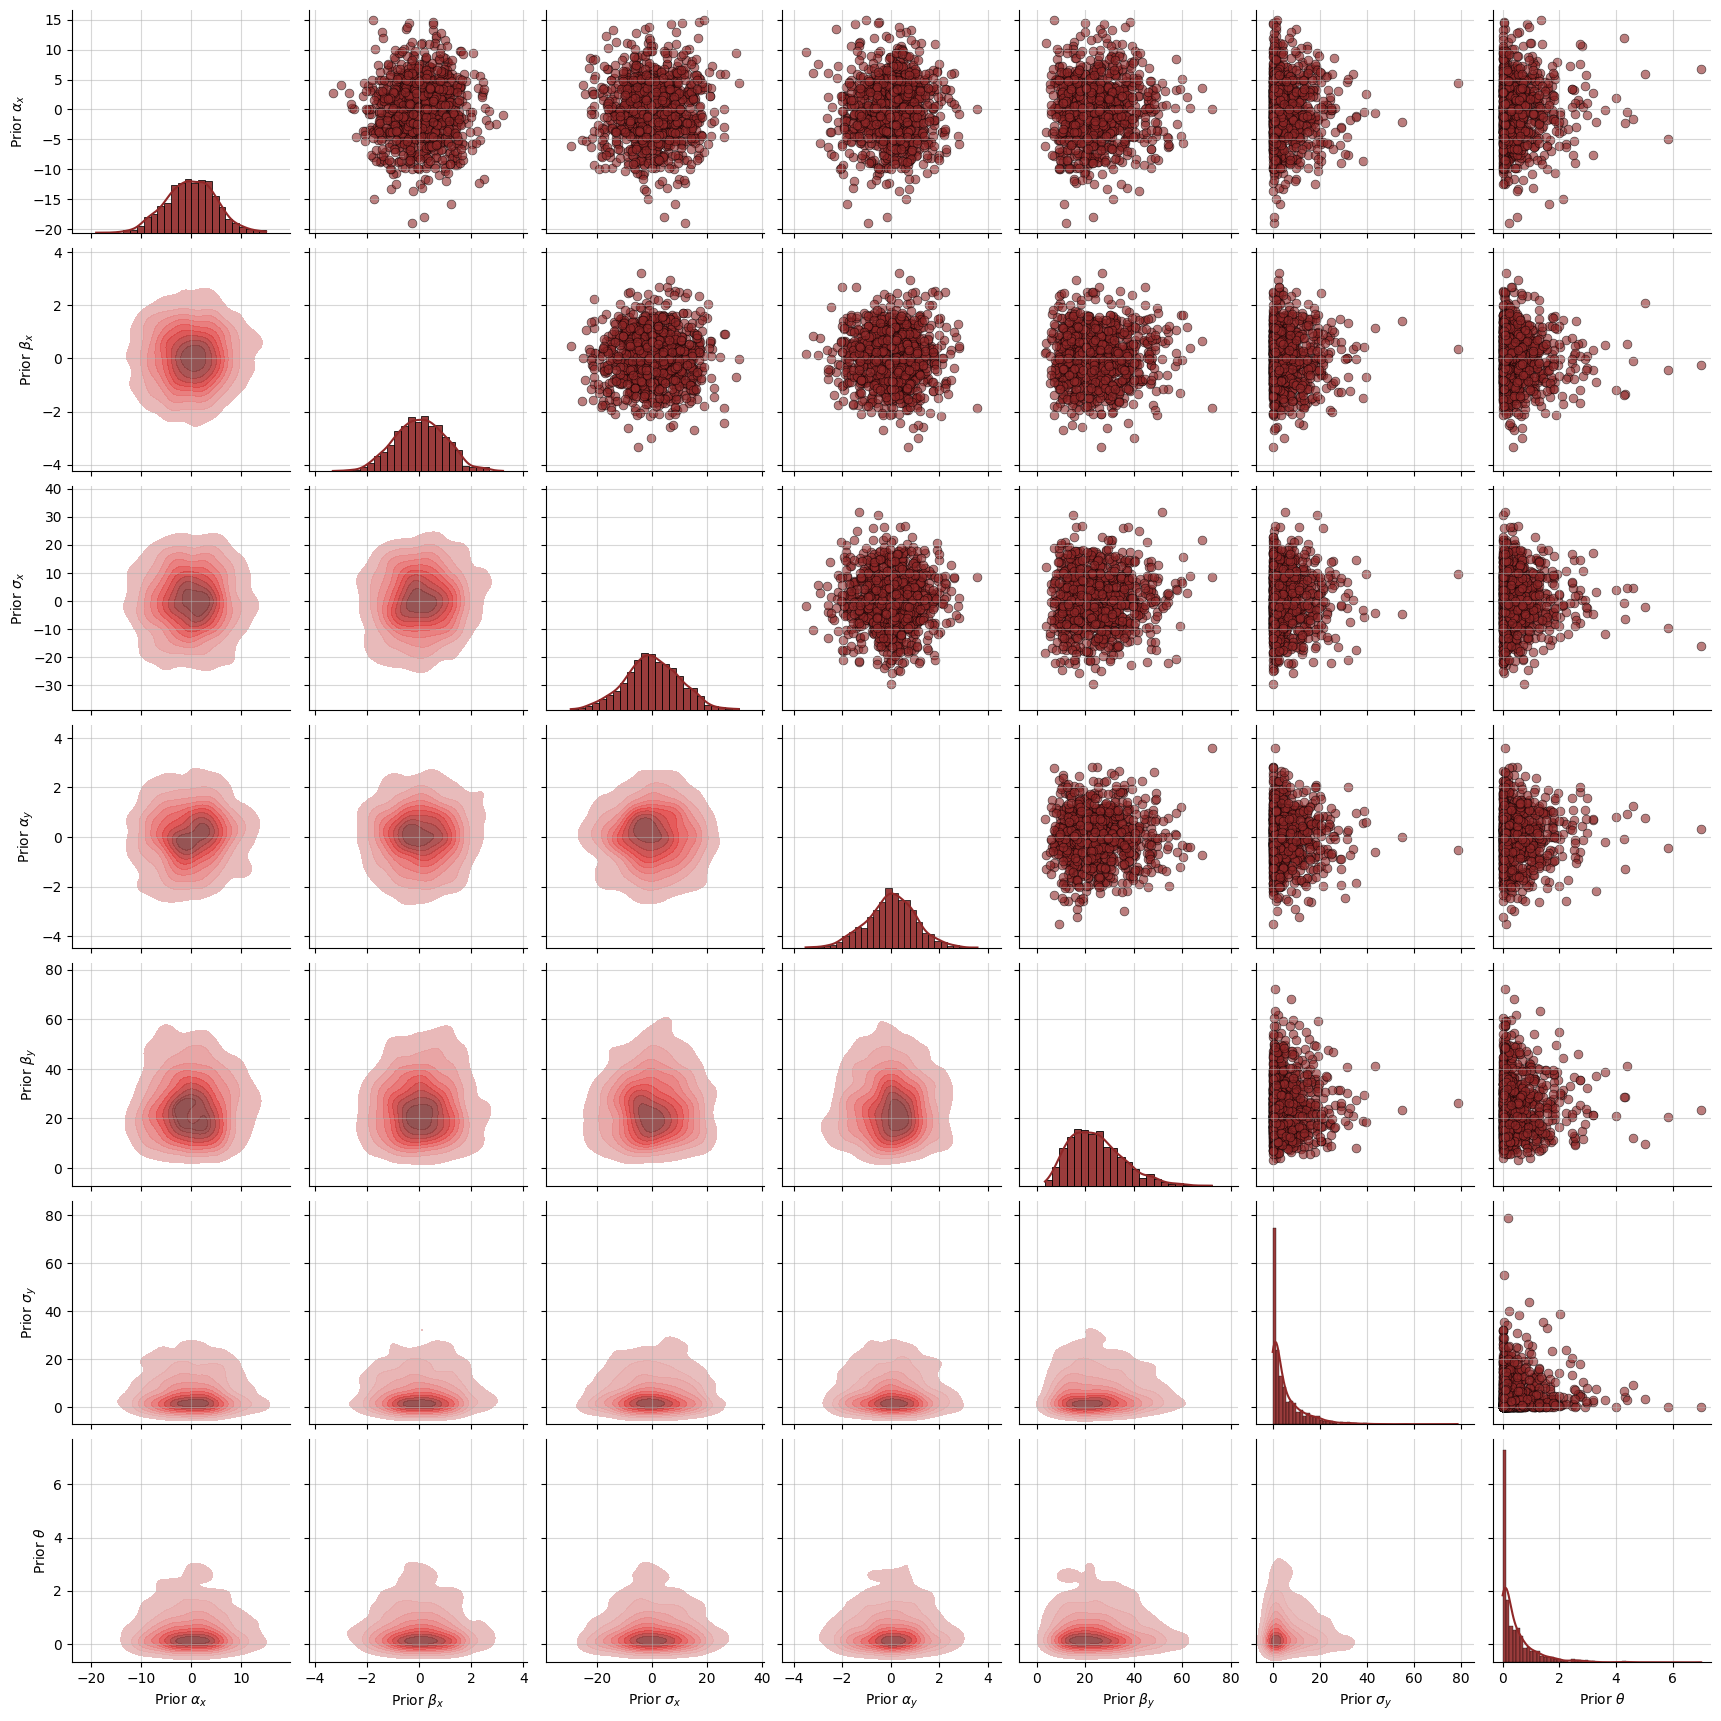

In [68]:
f = bf.simulation.plot_prior2d(prior=prior, n_samples=1000, param_names=PARAMS)

In [69]:
model = bf.simulation.GenerativeModel(
    prior=prior,
    simulator=simulator_fun,
    name="gaze",
    simulator_is_batched=False
)

INFO:root:Performing 2 pilot runs with the gaze model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2, 1000)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [70]:
sim = model(100)
sim['sim_data'].shape

(100, 2, 1000)

Neural approximator

In [71]:
summary_net = bf.summary_networks.DeepSet()

In [72]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=len(PARAMS),
    num_coupling_layers=6,
    coupling_settings={
        "dense_args": dict(kernel_regularizer=None), 
        "dropout": True
    }
)

In [73]:
amortizer = bf.amortizers.AmortizedPosterior(
    inference_net=inference_net,
    summary_net=summary_net
)

In [74]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [75]:
amortizer.summary()

Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  451836    
 ibleNetwork)                                                    
                                                                 
 deep_set_2 (DeepSet)        multiple                  195210    
                                                                 
Total params: 647046 (2.47 MB)
Trainable params: 646962 (2.47 MB)
Non-trainable params: 84 (336.00 Byte)
_________________________________________________________________


In [78]:
history = trainer.train_online(epochs=30, iterations_per_epoch=200, batch_size=32)

Training epoch 1:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 26:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 27:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 28:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 29:   0%|          | 0/200 [00:00<?, ?it/s]

Training epoch 30:   0%|          | 0/200 [00:00<?, ?it/s]

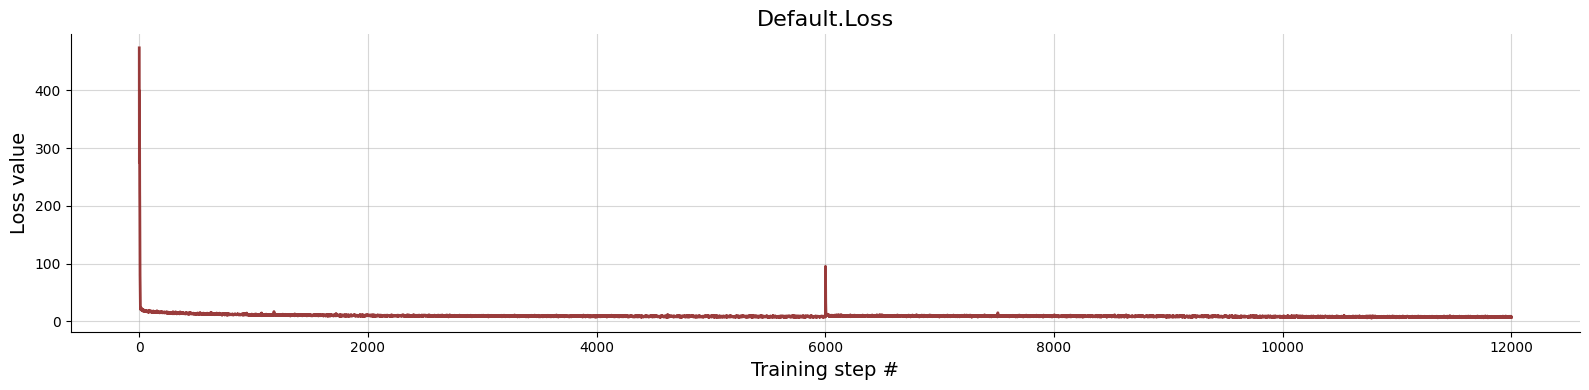

In [79]:
f = bf.diagnostics.plot_losses(history)

<Axes: >

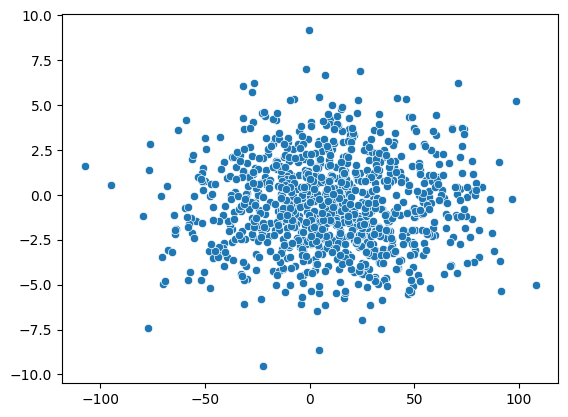

In [81]:
resim = trainer.configurator(model(500))
resim['summary_conditions'].shape
s = resim['summary_conditions'][0]
sns.scatterplot(x=s[0], y=s[1])

In [82]:
post_samples = amortizer.sample(resim, n_samples=1000)
post_samples.shape

(500, 1000, 7)

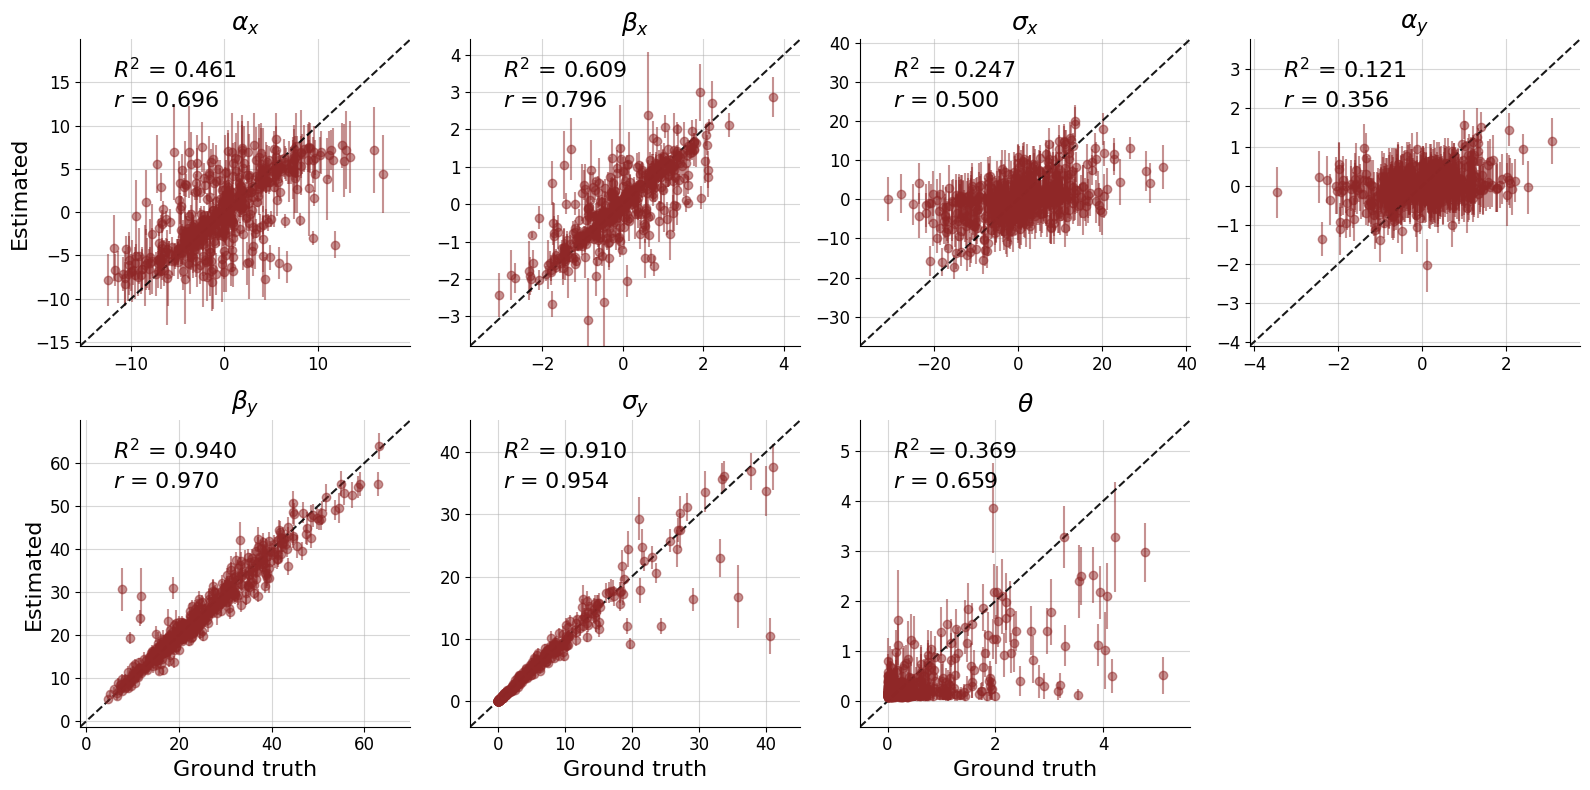

In [86]:
f = bf.diagnostics.plot_recovery(post_samples, resim['parameters'], param_names=PARAMS)

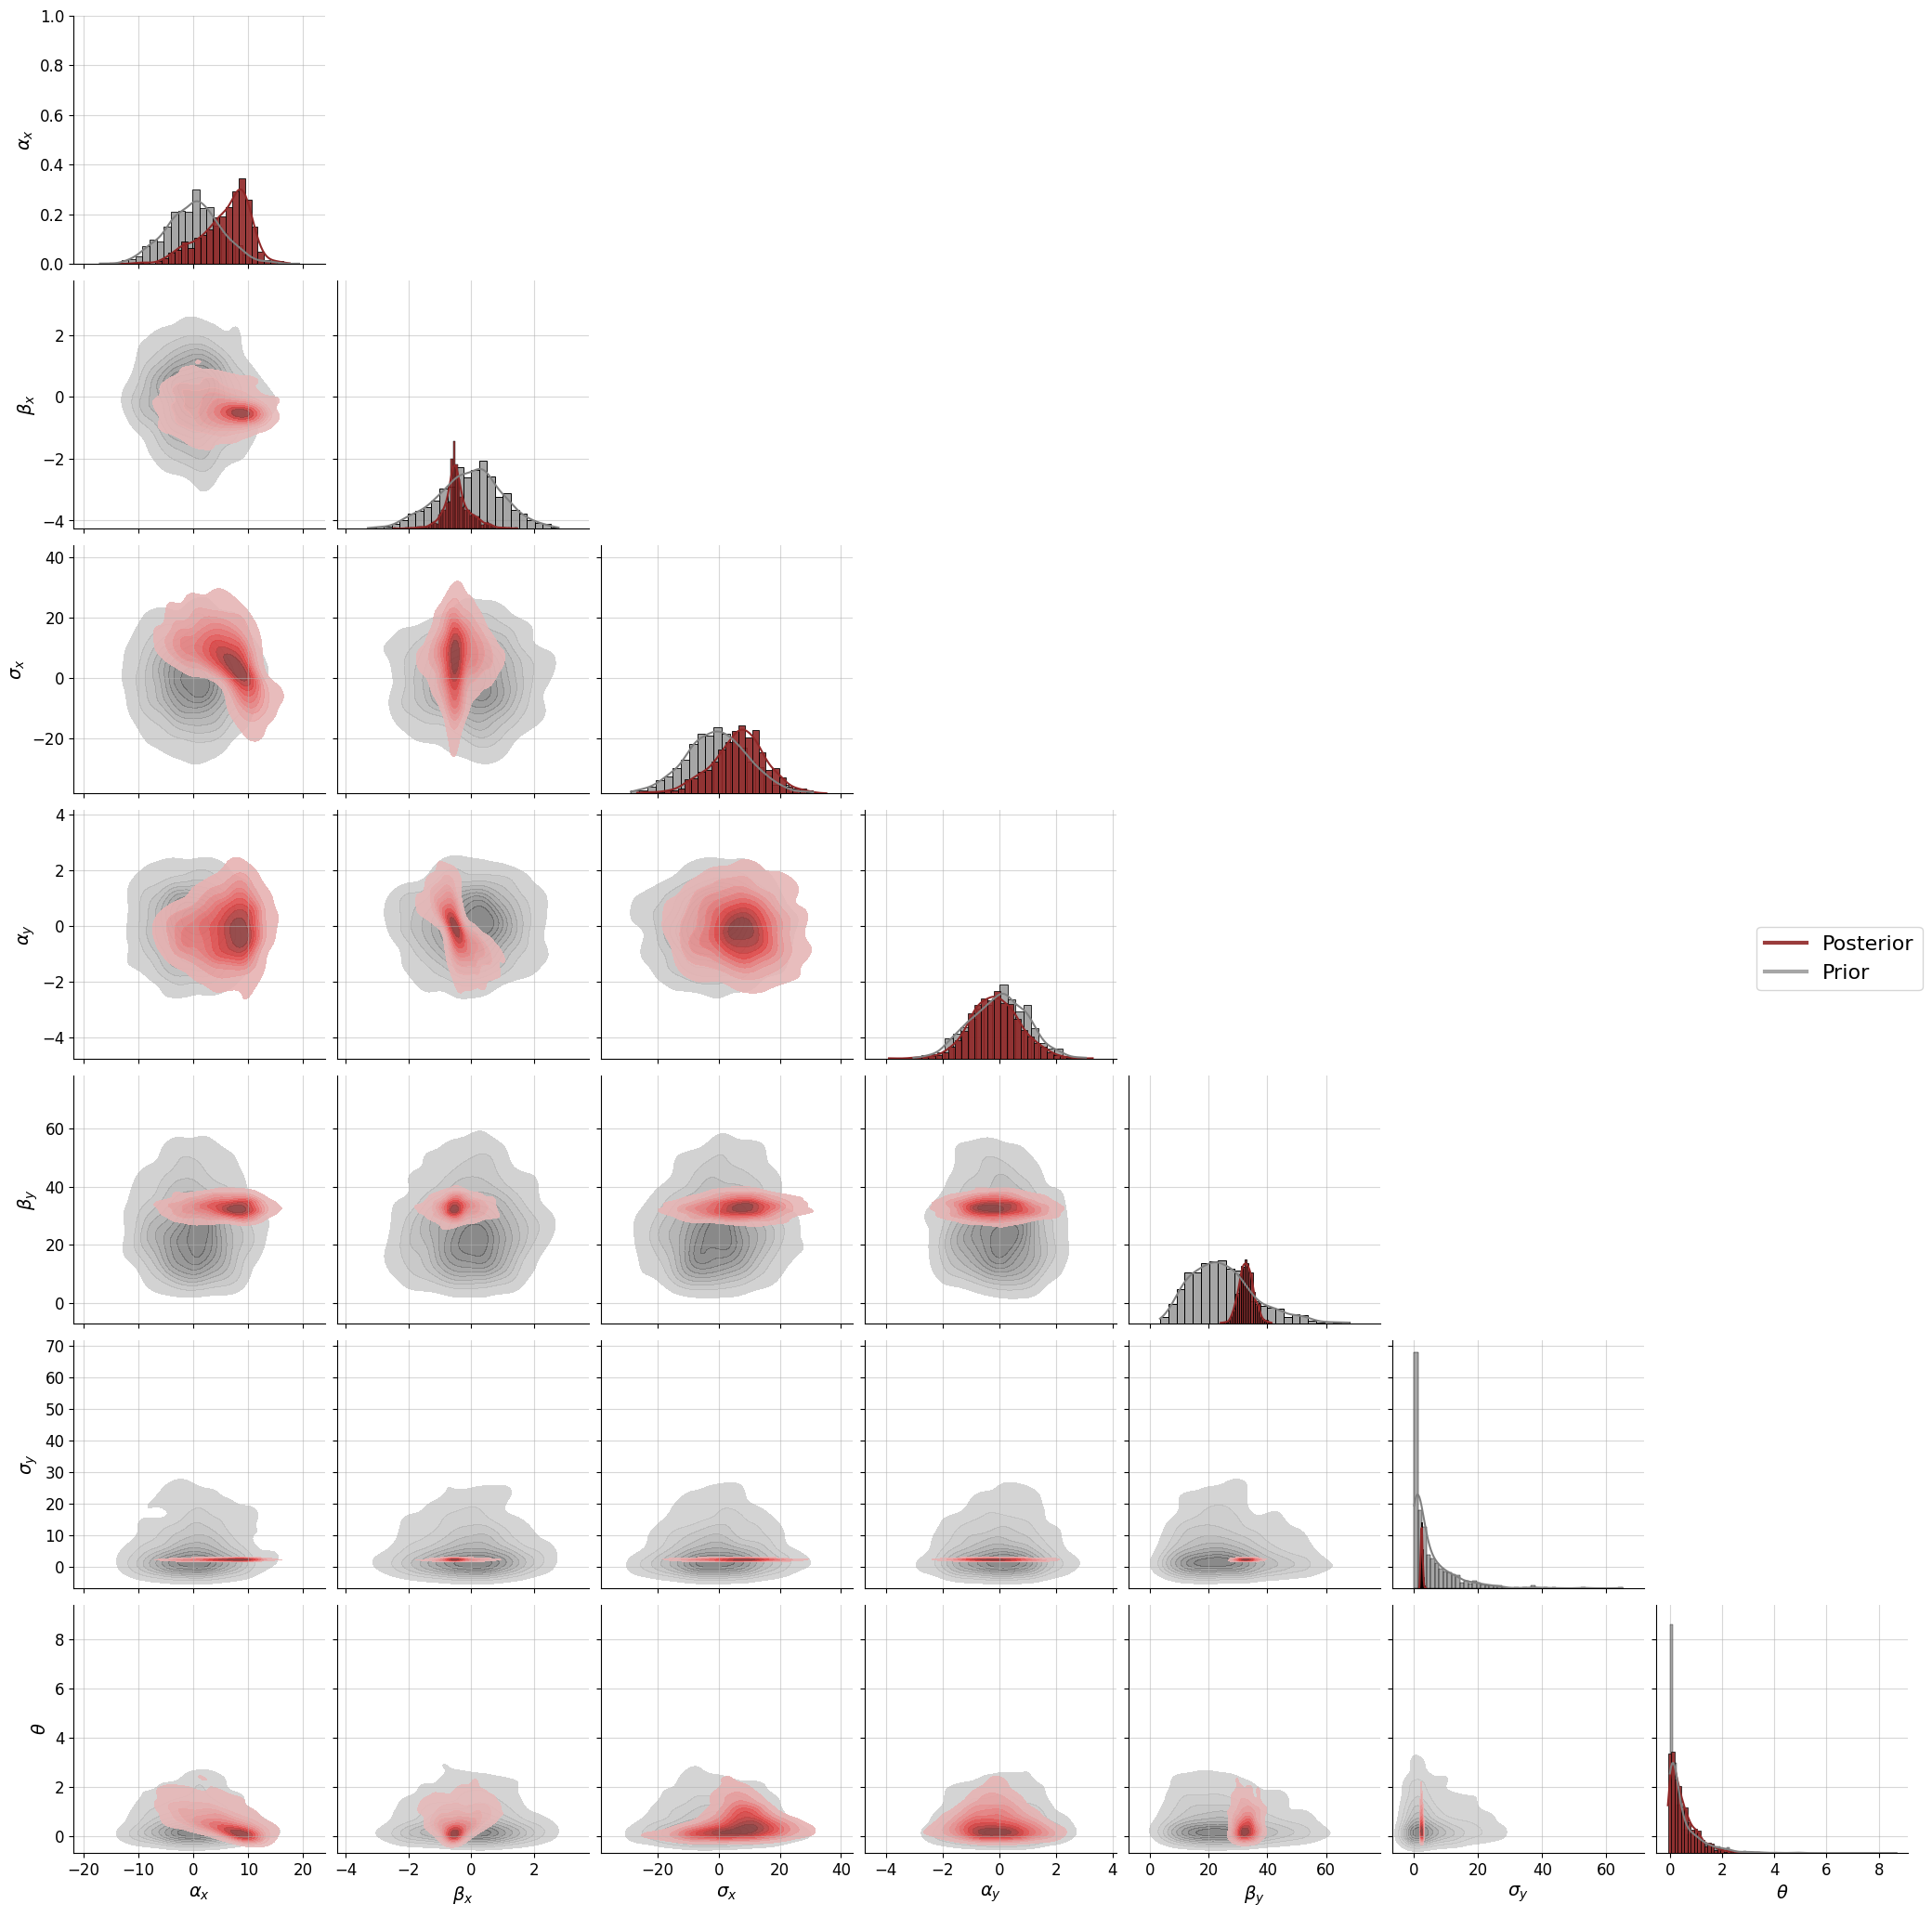

In [87]:
f = bf.diagnostics.plot_posterior_2d(post_samples[0], prior=prior)